## [Real or Fake] : Fake Job Description Prediction

This dataset contains 18k job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the job. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

### Importing Libraries:-

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score

In [2]:
df = pd.read_csv('/home/mihir/Desktop/Test/DataSet/RealOrFakeJobPosting/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Extracting Text Features:-

In [3]:
new_df = df[['title', 'company_profile', 'description', 'requirements', 'benefits', 'fraudulent']]
new_df = new_df.fillna('No Information')
new_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,No Information,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,No Information,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


## Target:-

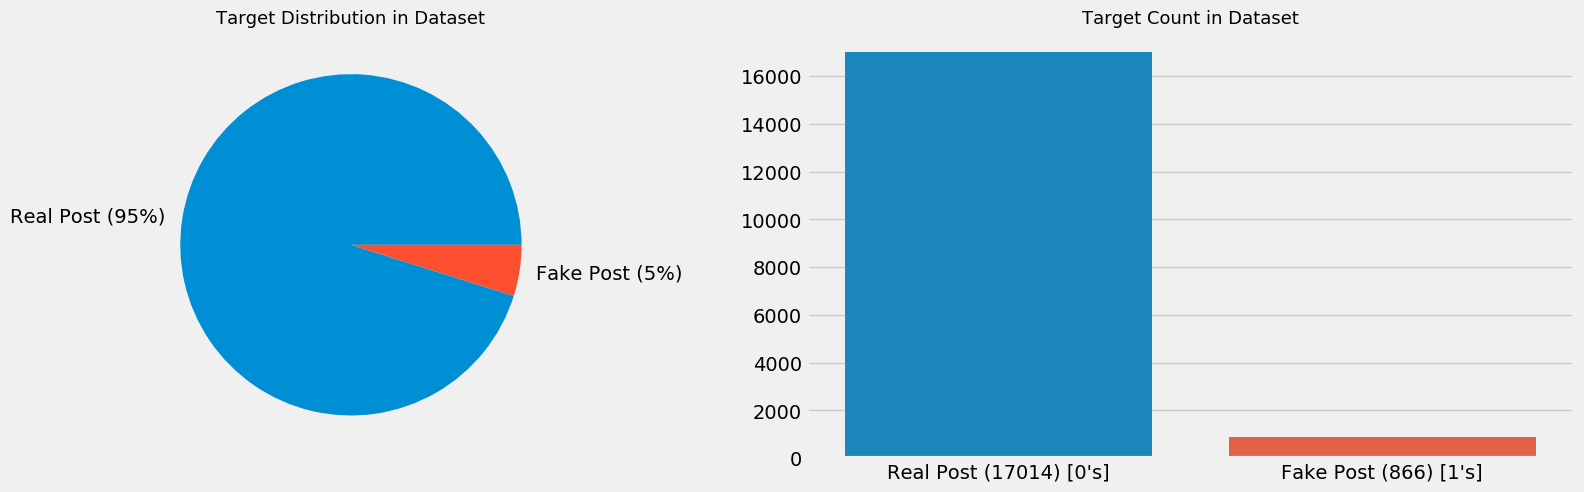

In [4]:
fig, axes = plt.subplots(ncols = 2, figsize = (17, 5), dpi = 100)
plt.tight_layout()

new_df['fraudulent'].value_counts().plot(kind = 'pie', ax = axes[0], labels = ['Real Post (95%)', 'Fake Post (5%)'])
temp = new_df['fraudulent'].value_counts()
sns.barplot(temp.index, temp, ax = axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(['Real Post (17014) [0\'s]', 'Fake Post (866) [1\'s]'])

axes[0].set_title('Target Distribution in Dataset', fontsize = 13)
axes[1].set_title('Target Count in Dataset', fontsize = 13)

plt.show()

Class distributions are **95% for 0 (Real Post)** and **5% for 1 (Fake Post)**. Target distribution is highly imbalanced. Accuracy metric is not useful here it will mislead the results. So, we have to look into Precision, Recall, F1 Score for model evaluation.

## Exploratory Data Analysis of tweets:-

First, we will do our very basic analysis, that is the charater level, word level and sentence level analysis.

### Number of charaters:-

Let's compare the number of character in the fake post and real post and try to distinguish pattern in the fake and real post based on number of characters used in the post.

#### Company profile:-

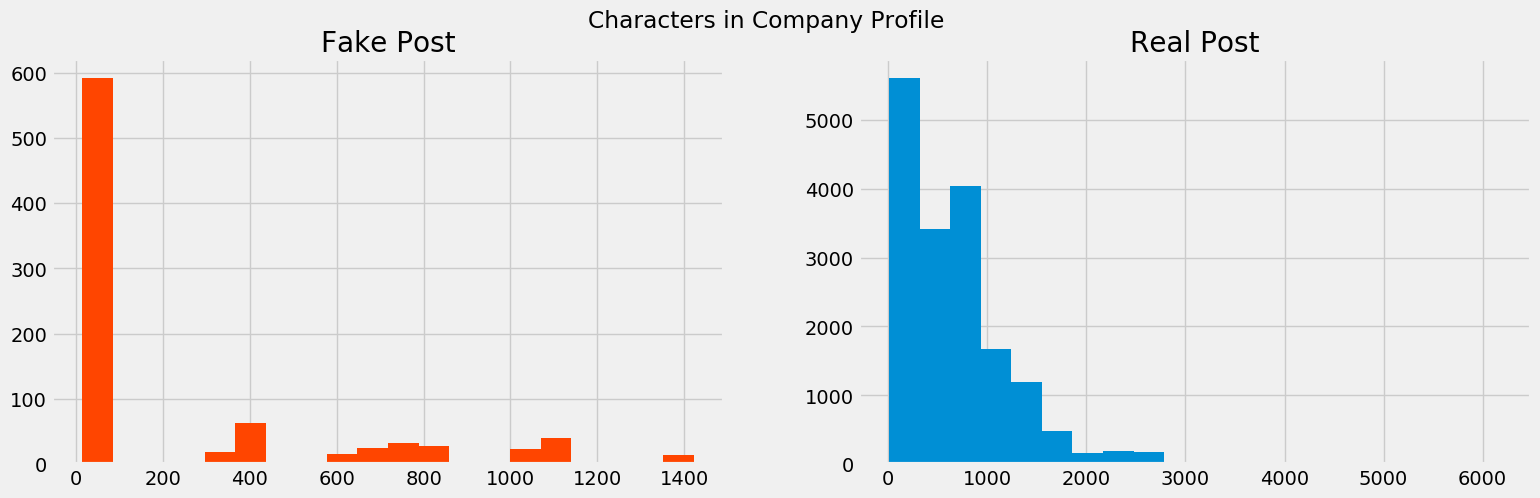

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (17, 5),dpi = 100)

length = new_df[new_df['fraudulent'] == 1]['company_profile'].str.len()
ax1.hist(length, bins = 20, color = 'orangered')
ax1.set_title('Fake Post')

length = new_df[new_df['fraudulent'] == 0]['company_profile'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')

fig.suptitle('Characters in Company Profile')
plt.show()

We can see that **fake post has less characters** in the company profile while **real post has more characters**.

#### Description:-

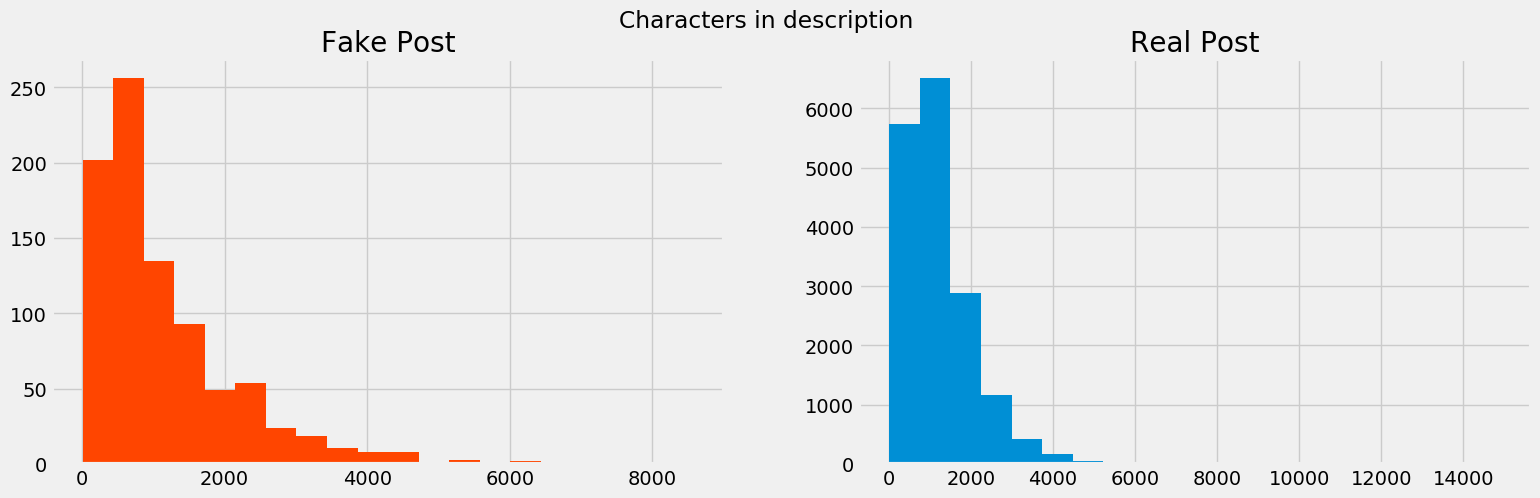

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (17, 5), dpi = 100)

length = new_df[new_df['fraudulent'] == 1]['description'].str.len()
ax1.hist(length, bins = 20, color = 'orangered')
ax1.set_title('Fake Post')

length = new_df[new_df['fraudulent'] == 0]['description'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')

fig.suptitle('Characters in description')
plt.show()

The distribution of characters in description of the fake and real post are similar but some fake post reach to 6000 to 6500 characters.

#### Requirements:-

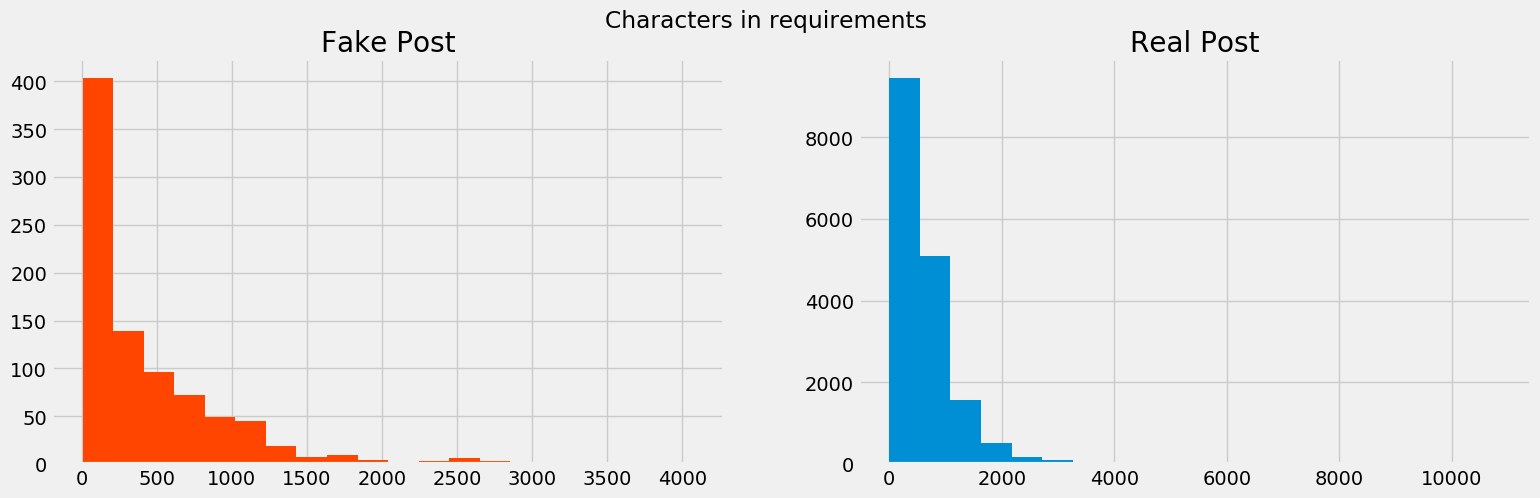

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (17, 5), dpi = 100)

length = new_df[new_df['fraudulent'] == 1]['requirements'].str.len()
ax1.hist(length, bins = 20, color = 'orangered')
ax1.set_title('Fake Post')

length = new_df[new_df['fraudulent'] == 0]['requirements'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')

fig.suptitle('Characters in requirements')
plt.show()

The distribution of characters in requirements of the fake and real post are similar.

#### Benifits:-

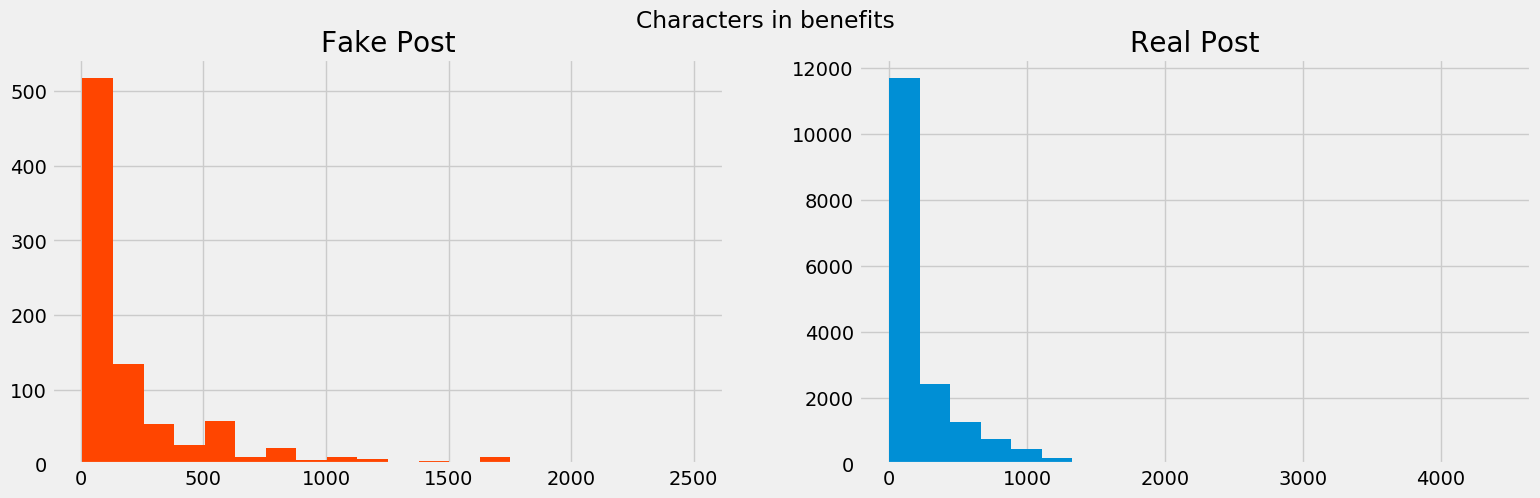

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (17, 5), dpi = 100)

length = new_df[new_df['fraudulent'] == 1]['benefits'].str.len()
ax1.hist(length, bins = 20, color = 'orangered')
ax1.set_title('Fake Post')

length = new_df[new_df['fraudulent'] == 0]['benefits'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')

plt.suptitle('Characters in benefits')
plt.show()

The distribution of characters in benefits of fake and real post is same around 1500 to 1800.

### Number of words:-

Let's compare the number of words in the fake post and real post and try to distinguish patterns in the fake and real post based on the number of words used in the post.

#### Company Profile:-

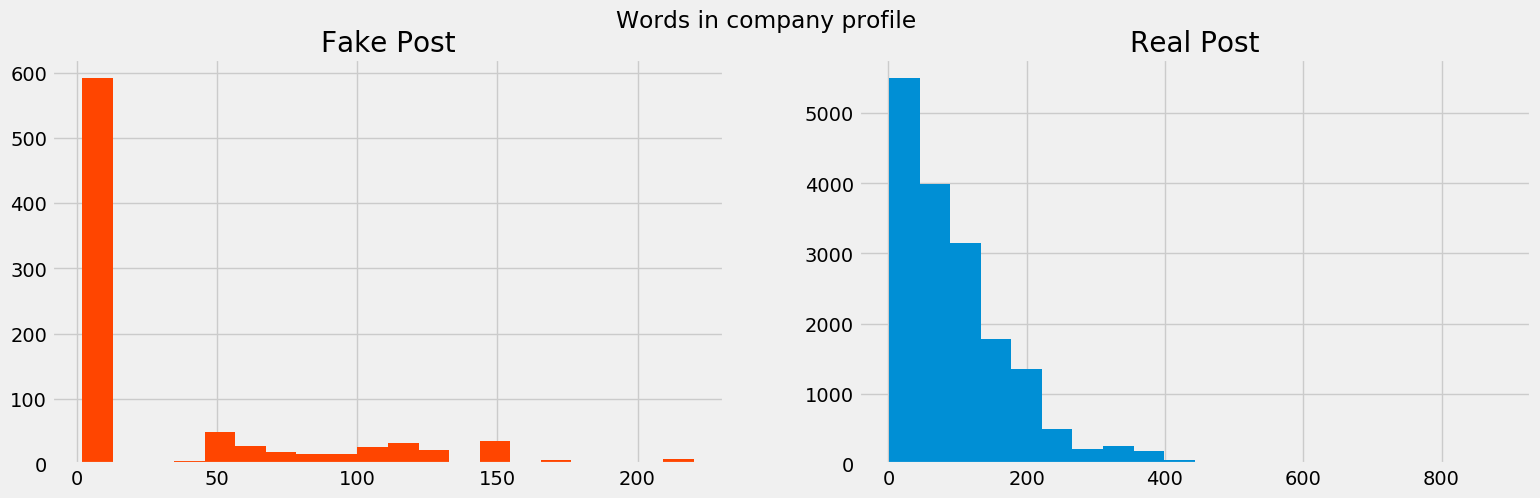

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (17, 5), dpi = 100)

num = new_df[new_df['fraudulent'] == 1]['company_profile'].str.split().map(lambda x: len(x))
ax1.hist(num, bins = 20, color = 'orangered')
ax1.set_title('Fake Post')

num = new_df[new_df['fraudulent'] == 0]['company_profile'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')

plt.suptitle('Words in company profile')
plt.show()

Patterns of words in company profile is same as character in company profile. **Fake post has less words** in the company profile while **real post has more words**.

#### Description:-

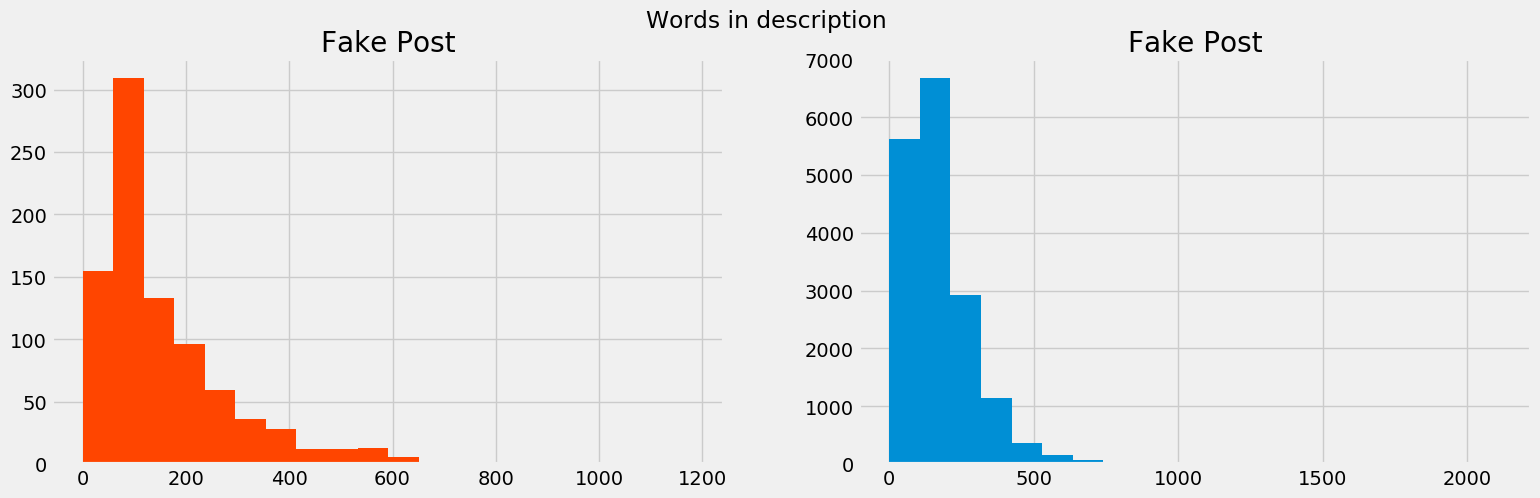

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (17, 5), dpi = 100)

num = new_df[new_df['fraudulent'] == 1]['description'].str.split().map(lambda x: len(x))
ax1.hist(num, bins = 20, color = 'orangered')
ax1.set_title('Fake Post')

num = new_df[new_df['fraudulent'] == 0]['description'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Fake Post')

plt.suptitle('Words in description')
plt.show()

Both the post has similar distribution of words in description.

#### Requirements:-

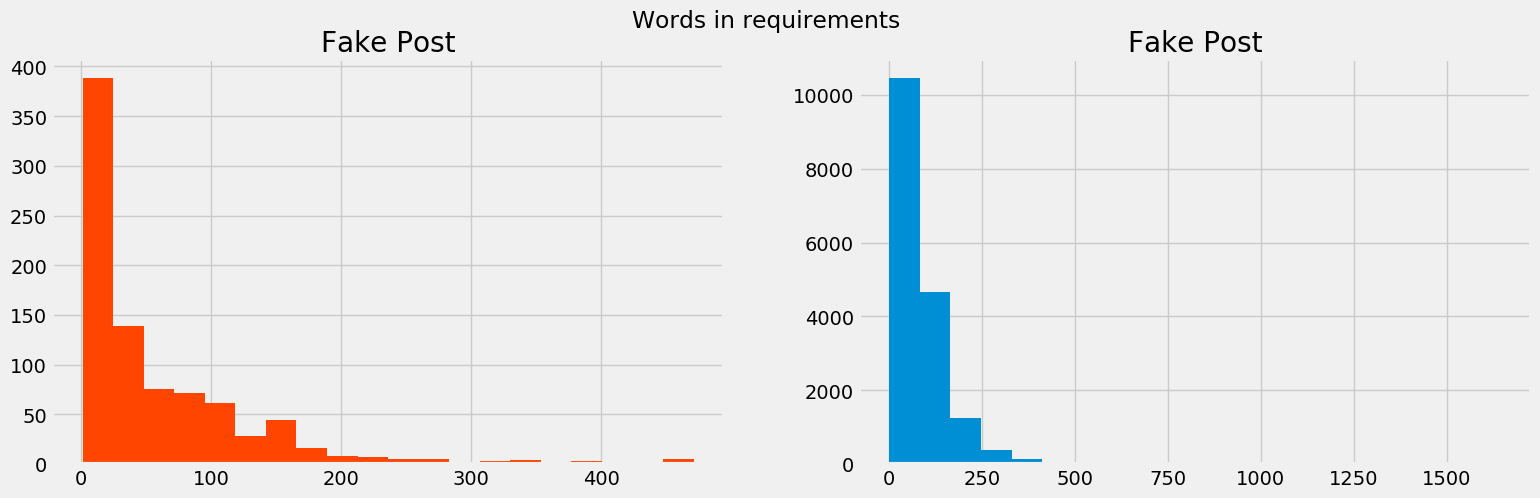

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (17, 5), dpi = 100)

num = new_df[new_df['fraudulent'] == 1]['requirements'].str.split().map(lambda x: len(x))
ax1.hist(num, bins = 20, color = 'orangered')
ax1.set_title('Fake Post')

num = new_df[new_df['fraudulent'] == 0]['requirements'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Fake Post')

plt.suptitle('Words in requirements')
plt.show()

The distribution of words in requirements of fake and real post is similar.

#### Benefits:-

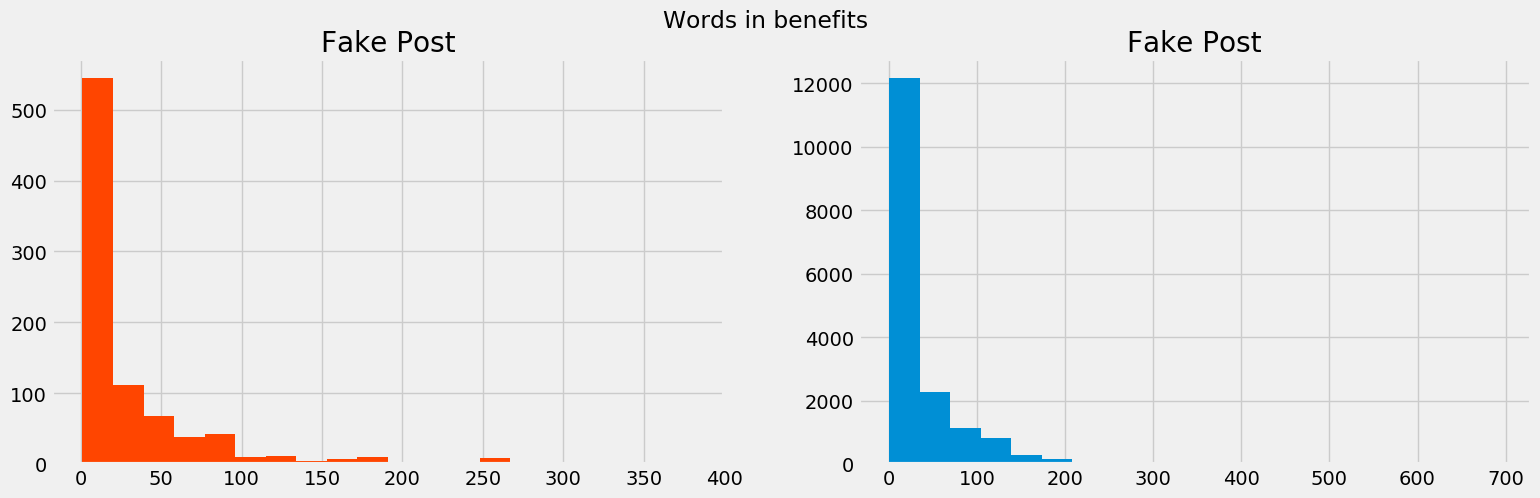

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (17, 5), dpi = 100)

num = new_df[new_df['fraudulent'] == 1]['benefits'].str.split().map(lambda x: len(x))
ax1.hist(num, bins = 20, color = 'orangered')
ax1.set_title('Fake Post')

num = new_df[new_df['fraudulent'] == 0]['benefits'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Fake Post')

plt.suptitle('Words in benefits')
plt.show()

The distribution of words in benefits of the fake and real post are also similar.

## Data preprocessing:-

Concat the text data for preprocessing and modelling.

In [13]:
text = new_df[new_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)), axis = 1)
target = df['fraudulent']

print(len(text))
print(len(target))

17880
17880


### Ngram Analysis:-

Most common unigram exist in **both classes** are mostly punctuations, stop words or numbers. It is better to clean the before modelling since they don't give much information about target.

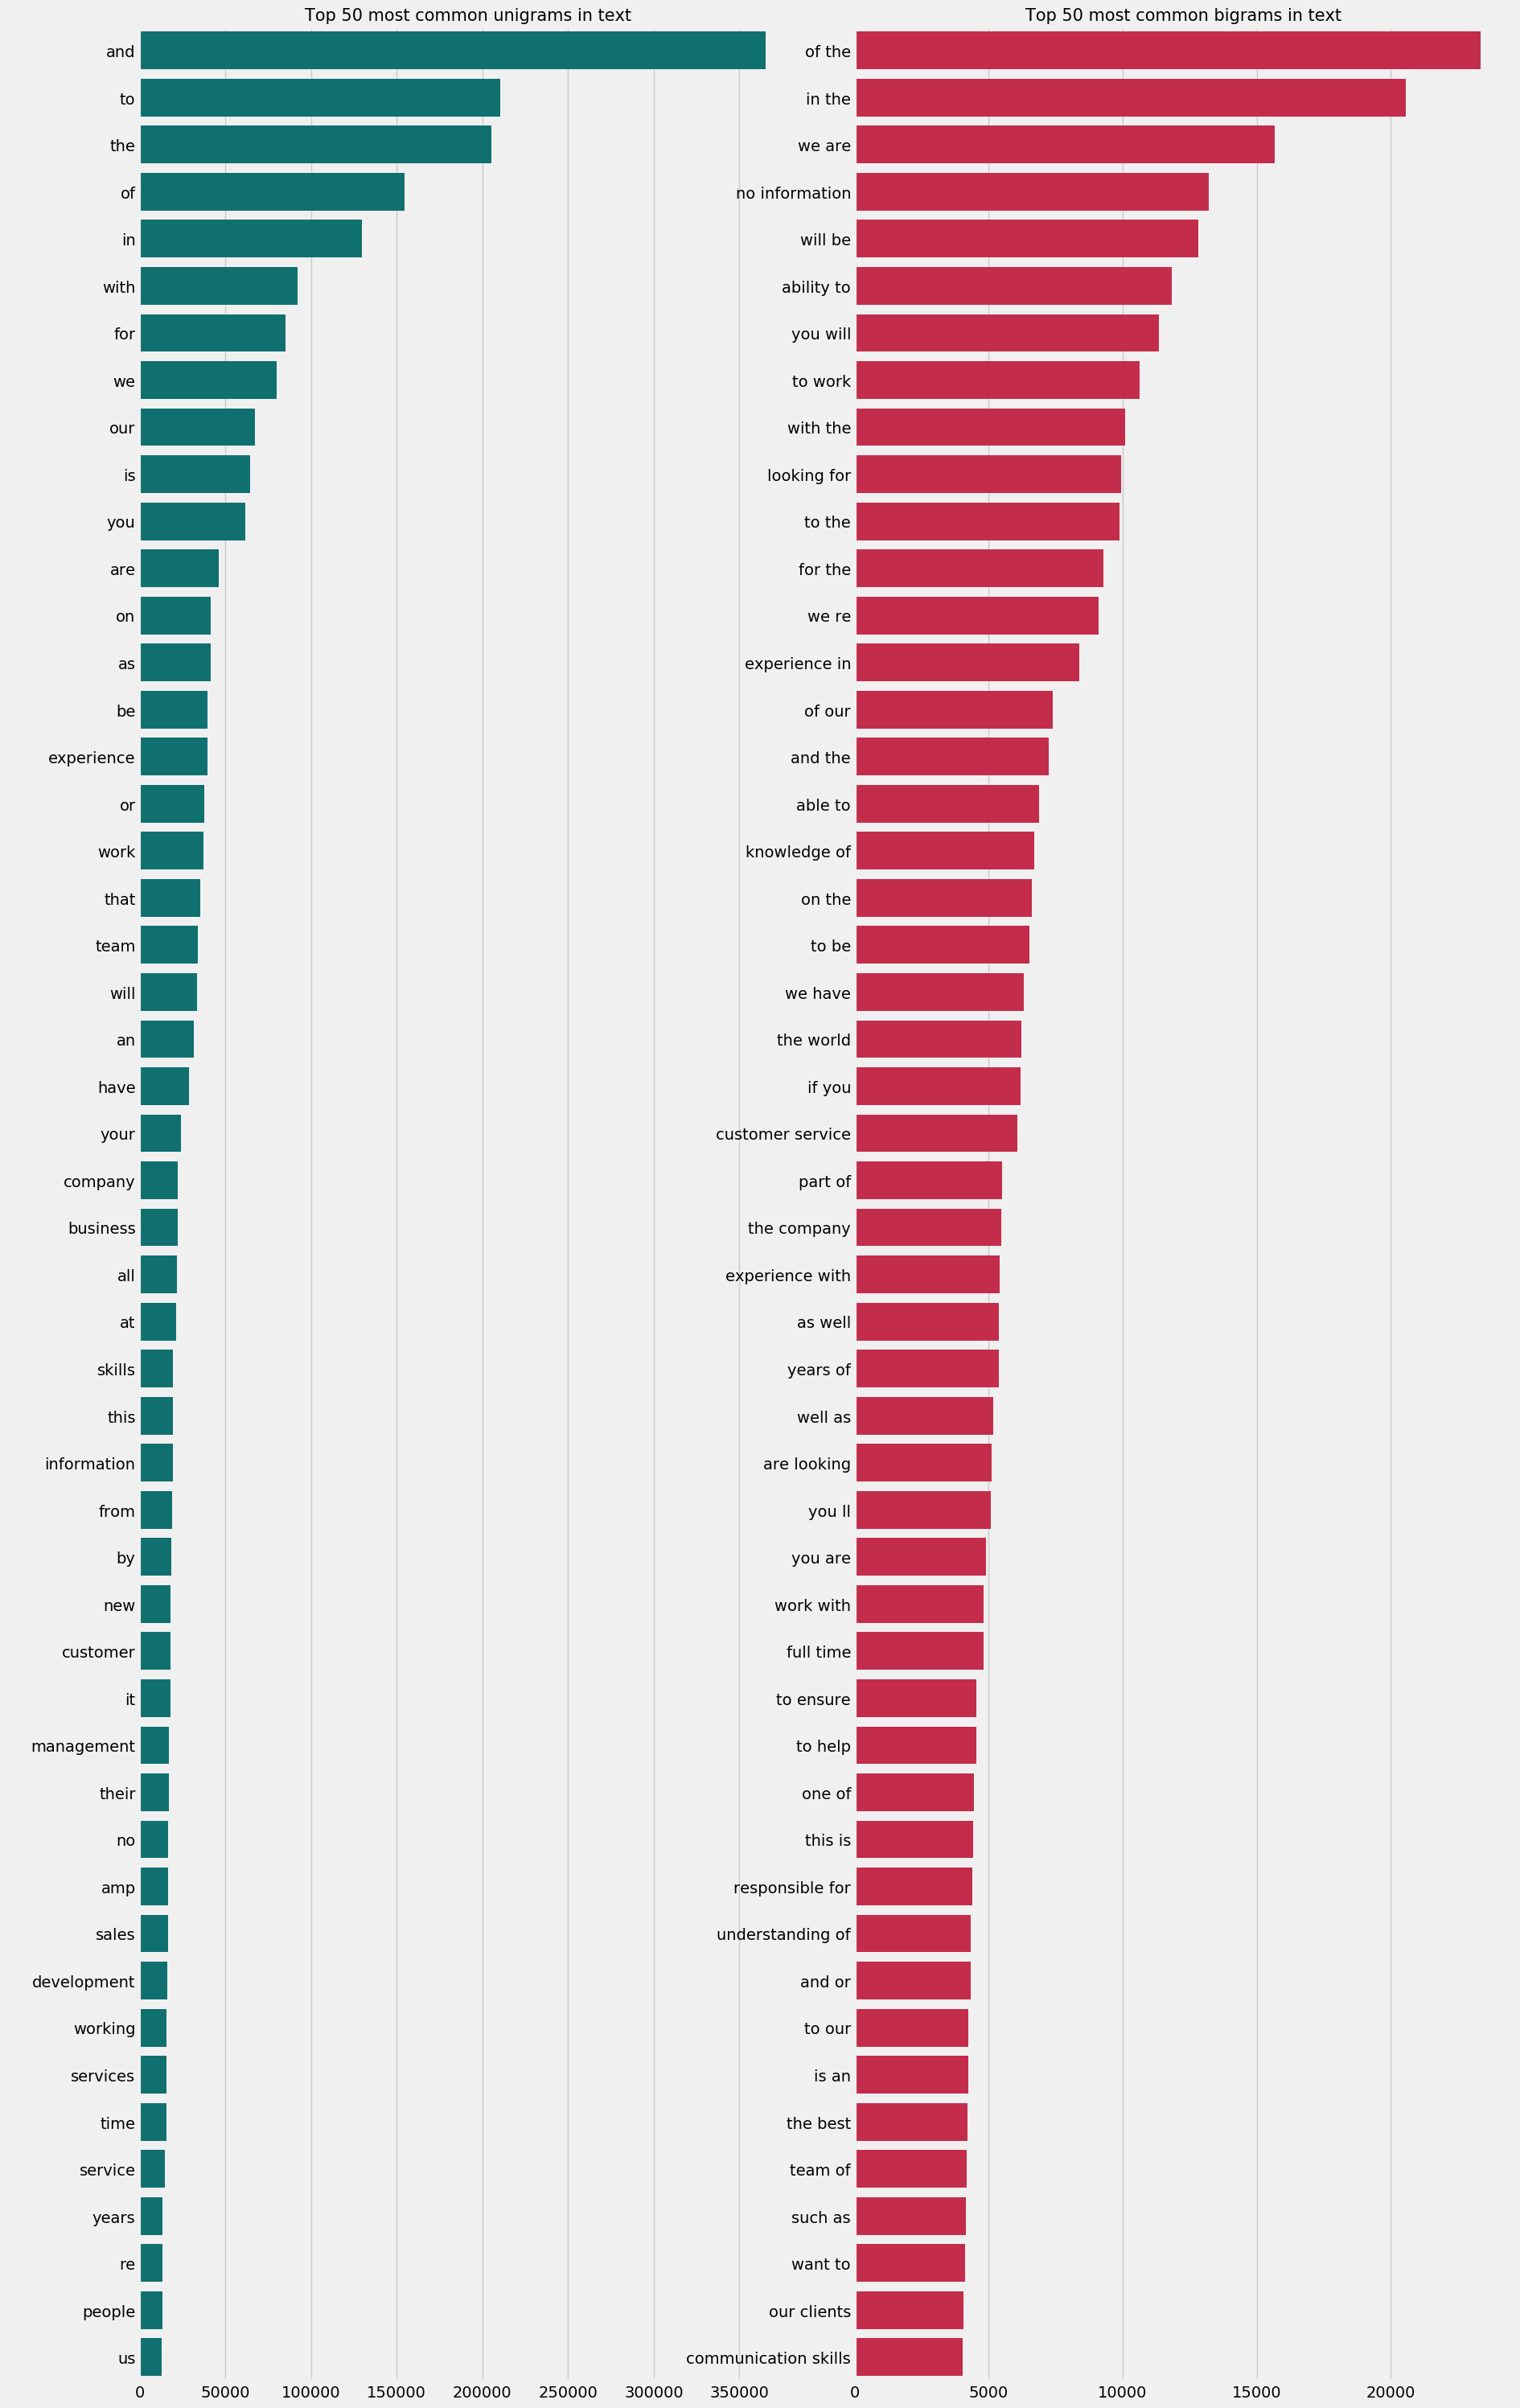

In [14]:
def get_top_tweet_unigrams(corpus, n = None):
    vec = CountVectorizer(ngram_range = (1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

def get_top_tweet_bigram(corpus, n = None):
    vec = CountVectorizer(ngram_range = (2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

fig, axes = plt.subplots(ncols = 2, figsize = (18, 30), dpi = 100)
plt.tight_layout()

top_unigrams = get_top_tweet_unigrams(text)[:50]
x, y = map(list, zip(*top_unigrams))
sns.barplot(x = y, y = x, ax = axes[0], color = 'teal')

top_bigrams = get_top_tweet_bigram(text)[:50]
x, y = map(list, zip(*top_bigrams))
sns.barplot(x = y, y = x, ax = axes[1], color = 'crimson')

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Top 50 most common unigrams in text', fontsize = 15)
axes[1].set_title('Top 50 most common bigrams in text', fontsize = 15)

plt.show()

### Text Cleaning:-

In [15]:
%%time
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

text = text.apply(lambda x: clean_text(x))
text.head(3)

CPU times: user 7.59 s, sys: 19.4 ms, total: 7.61 s
Wall time: 7.61 s


0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
dtype: object

### Tokenizer:-

In [16]:
%%time
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

text = text.apply(lambda x: tokenizer.tokenize(x))
text.head(3)

CPU times: user 1.74 s, sys: 88.2 ms, total: 1.83 s
Wall time: 1.83 s


0    [marketing, internwere, and, weve, created, a,...
1    [customer, service, cloud, video, seconds, the...
2    [commissioning, machinery, assistant, cmavalor...
dtype: object

Removing stop words belonging to English language.

In [17]:
%%time
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

text = text.apply(lambda x: remove_stopwords(x))

CPU times: user 10min 34s, sys: 58 s, total: 11min 32s
Wall time: 11min 33s


In [18]:
%%time
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

text = text.apply(lambda x: combine_text(x))

CPU times: user 145 ms, sys: 8.1 ms, total: 153 ms
Wall time: 154 ms


## Baseline Model

In [19]:
#Stratified k-fold cross-validation with an imbalanced dataset
kfold = StratifiedKFold(n_splits = 5, shuffle = True)
auc_buf = []
cnt = 0

#Enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(text, target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = text[train_ix], text[test_ix]
    train_y, test_y = target[train_ix], target[test_ix]
    
    #Applying count vectorizer
    count_vectorizer = CountVectorizer()
    train_X_vec = count_vectorizer.fit_transform(train_X)
    test_X_vec = count_vectorizer.transform(test_X)
    
    clf = LogisticRegression(C = 0.1, solver = 'lbfgs', max_iter = 1000)
    clf.fit(train_X_vec, train_y)
    preds = clf.predict(test_X_vec)
    
    auc = roc_auc_score(test_y, preds)
    print('{} AUC: {}'.format(cnt, auc))
    auc_buf.append(auc)
    
    cnt += 1

print('Auc mean score = {:.6f}'.format(np.mean(auc_buf)))
print('Auc std score = {:.6f}'.format(np.std(auc_buf)))

Fold 1
0 AUC: 0.8283043353450458
Fold 2
1 AUC: 0.8576468569894975
Fold 3
2 AUC: 0.8426082732169338
Fold 4
3 AUC: 0.8574999278093622
Fold 5
4 AUC: 0.8608931865636845
Auc mean score = 0.849391
Auc std score = 0.012303


It seems simple Logistic Regression model performs well. **AUC of 84** demonstrating the good fitting of choosen model. Apply Glove for vectorization with xgboost.

## GloVe for Vectorization

Here we will use GloVe pretrained corpus model to represent our words. It is available in 3 varieties :
1. 50D
2. 100D
3. 200D

We will try 200 D here.

Loading the GloVe vectors in a dictionary.

In [20]:
embeddings_index = {}

with open('/home/mihir/Desktop/Test/DataSet/GloVe/glove-global-vectors-for-word-representation/glove.6B.200d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embeddings_index[word] = vectors
        
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stopwords.words('english')]
    words = [w for w in words if w.isalpha()]
    
    M = list()
    for w in words:
        try:
            M.append(embeddings_index_index[w])
        except:
            continue
            
    M = np.array(M)
    v = M.sum(axis = 0)
    if type(v) != np.ndarray:
        return np.zeros(200)
    return v / np.sqrt((v ** 2).sum())

Defining XGBC hyper parameters

In [22]:
xgbc_params = {
    'n_estimators': (200, 500),
    'tree_method': ['hist'],
    'learning_rate': (0.01, 0.05),
    'subsample': (0.3, 0.9),
    'max_depth': [3, 4, 9],
    'colsample_bytree': (0.5, 0.9),
    'min_child_weight': [3, 6],
    'random_state': [44]
              }

In [23]:
# Stratified k-fold cross-validation with an imbalanced dataset
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
auc_buf = []   
cnt = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(text, target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = text[train_ix], text[test_ix]
    train_y, test_y = target[train_ix], target[test_ix]
    
    # create glove features
    xtrain_glove = np.array([sent2vec(x) for x in tqdm(train_X)])
    xtest_glove = np.array([sent2vec(x) for x in tqdm(test_X)])
    xtrain_glove.shape,  xtest_glove.shape
    
    # Define the model
    xgbc = xgb.XGBClassifier(tree_method='hist', random_state = 101, n_job = -1)
    
    grid = GridSearchCV(xgbc, param_grid=xgbc_params, verbose = 0, cv = 5, scoring='roc_auc', n_jobs = -1)
    
    # Fit using grid search.
    grid.fit(xtrain_glove, train_y)
    xgbc_best_params = grid.best_params_
    print('And Best Parameters:', xgbc_best_params)
    
    #Instantiate the models with optimized hyperparameters
    clf = xgb.XGBClassifier(**xgbc_best_params)
    
    clf.fit(xtrain_glove, train_y)
    preds = clf.predict(xtest_glove)
    
    auc = roc_auc_score(test_y, preds)
    print('{} AUC: {}'.format(cnt, auc))
    auc_buf.append(auc)

    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('AUC std score = {:.6f}'.format(np.std(auc_buf)))

  0%|          | 3/14304 [00:00<09:23, 25.39it/s]

Fold 1


100%|██████████| 3576/3576 [01:36<00:00, 37.14it/s]


And Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'random_state': 44, 'subsample': 0.3, 'tree_method': 'hist'}


  0%|          | 3/14304 [00:00<09:38, 24.71it/s]

0 AUC: 0.5
Fold 2


100%|██████████| 3576/3576 [01:49<00:00, 32.68it/s]


And Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'random_state': 44, 'subsample': 0.3, 'tree_method': 'hist'}


  0%|          | 2/14304 [00:00<12:47, 18.62it/s]

1 AUC: 0.5
Fold 3


100%|██████████| 3576/3576 [01:35<00:00, 37.38it/s]


And Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'random_state': 44, 'subsample': 0.3, 'tree_method': 'hist'}


  0%|          | 0/14304 [00:00<?, ?it/s]

2 AUC: 0.5
Fold 4


100%|██████████| 3576/3576 [03:20<00:00, 17.81it/s]


And Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'random_state': 44, 'subsample': 0.3, 'tree_method': 'hist'}


  0%|          | 1/14304 [00:00<27:21,  8.71it/s]

3 AUC: 0.5
Fold 5


100%|██████████| 3576/3576 [01:40<00:00, 35.76it/s]


And Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'random_state': 44, 'subsample': 0.3, 'tree_method': 'hist'}
4 AUC: 0.5
AUC mean score = 0.500000
AUC std score = 0.000000


I can safely be said that LR in general is a better solution atdiscriminating between positive and negative than XGBoost.LR has an AUC curve of 84%~. We can imporve the results by applying different approaches.